In [1]:
# %matplotlib widgets
import os
import csv
import sys
from skimage.io import imread

import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
import torchvision.transforms as T

import gudhi as gd
import gudhi.representations

from PIL import Image
from tqdm import tqdm

In [2]:
# path = 'data/val_images/n01667114/img_jccjn.jpeg'
# path = 'data/val_images/n07717410/img_blnff.jpeg'
path = 'data/val_images/n03924679/img_rvzhk.jpeg'

# im = imread(path)
# im_gray = im.mean(axis=2)
# im_gray /= im_gray.max()
# plt.imshow(im_gray, cmap='gray')

## Topological features

### Handcrafted features 

In [43]:
def compute_landscape(im, resolution, n_landscapes=3):
    im_gray = im.mean(axis=-1)
    im_gray /= im_gray.max()
    cubical_complex = gd.CubicalComplex(top_dimensional_cells=im_gray.flatten(), dimensions=im_gray.shape)
    cubical_complex.compute_persistence()

    ls = gd.representations.Landscape(resolution=resolution, num_landscapes=n_landscapes)
    diagram = cubical_complex.persistence_intervals_in_dimension(1)
    print(len(diagram))
    L = ls.fit_transform([diagram])
    return L
resolution = 200
L = compute_landscape(im, resolution=resolution)
L.shape

620


(1, 600)

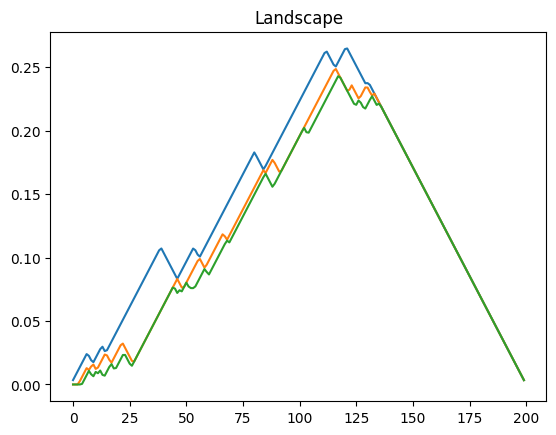

In [31]:
plt.plot(L[0][:resolution])
plt.plot(L[0][resolution:2*resolution])
plt.plot(L[0][2*resolution:3*resolution])
plt.title("Landscape")
plt.show()

In [58]:
root_dir = 'data/val_images'
all_classes = os.listdir(root_dir)
classes_to_idx = {}
with open('class2category.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        classes_to_idx[row[0]] = int(row[1])        

for cls_name in tqdm(all_classes):
    
    all_imgs_path = os.path.join(root_dir, cls_name) # data/val_images/n3648
    all_imgs_files = os.listdir(all_imgs_path)
    # current_cls = classes_to_idx[cls_name]
    for img_file in all_imgs_files:
        img_path = os.path.join(all_imgs_path, img_file)
        print(img_path)
        # im = imread(img_path)
        # landscape = compute_landscape(im, resolution=resolution)[0]
        # feature_path = img_path.replace('jpeg', 'npy')
        # np.save(feature_path, landscape)

100%|████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 12802.73it/s]

data/val_images/n03924679/img_rvzhk.jpeg
data/val_images/n03924679/img_5n4uc.jpeg
data/val_images/n03924679/img_x3vs0.jpeg
data/val_images/n03924679/img_2d3tv.jpeg
data/val_images/n03924679/img_a94wf.jpeg
data/val_images/n02487347/img_vqje9.jpeg
data/val_images/n02487347/img_a13uj.jpeg
data/val_images/n02487347/img_zic3r.jpeg
data/val_images/n02487347/img_8z7mn.jpeg
data/val_images/n02487347/img_37kg4.jpeg
data/val_images/n03814906/img_wp6li.jpeg
data/val_images/n03814906/img_5u9ac.jpeg
data/val_images/n03814906/img_qm0g5.jpeg
data/val_images/n03814906/img_q24uw.jpeg
data/val_images/n03814906/img_wuq48.jpeg
data/val_images/n07590611/img_ct6dg.jpeg
data/val_images/n07590611/img_g55mh.jpeg
data/val_images/n07590611/img_m9w1w.jpeg
data/val_images/n07590611/img_29qsg.jpeg
data/val_images/n07590611/img_751o5.jpeg
data/val_images/n02106550/img_iz4n4.jpeg
data/val_images/n02106550/img_dcml5.jpeg
data/val_images/n02106550/img_9z9z7.jpeg
data/val_images/n02106550/img_qjvax.jpeg
data/val_images/

### Torch topological 

In [3]:
from torch_topological.nn import CubicalComplex

In [6]:
im = Image.open(path)
im = T.Compose([
    T.Resize((224,224)),
    T.ToTensor()
])(im).unsqueeze(0)

ccomplex = CubicalComplex()
out = ccomplex(im.mean(dim=1, keepdims=True))

In [69]:
pers_array = out[0][0][1].diagram
type(pers_array)

torch.Tensor

In [74]:
torch.ones(5) / torch.ones(5).sum()

tensor([0.2000, 0.2000, 0.2000, 0.2000, 0.2000])

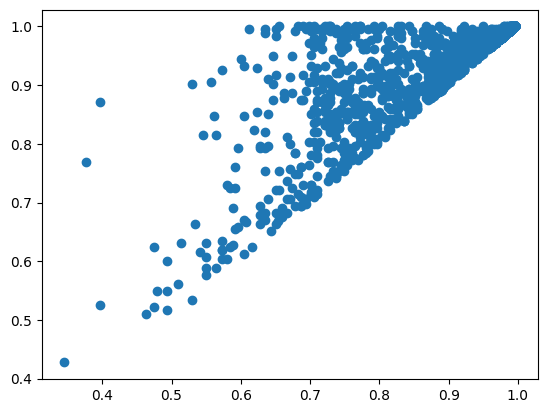

In [63]:
# out[0][2][1].pairing.shape, out[0][2][1].diagram.shape
pers_array = out[0][0][1].diagram.numpy()
plt.scatter(pers_array[:,0], pers_array[:,1])

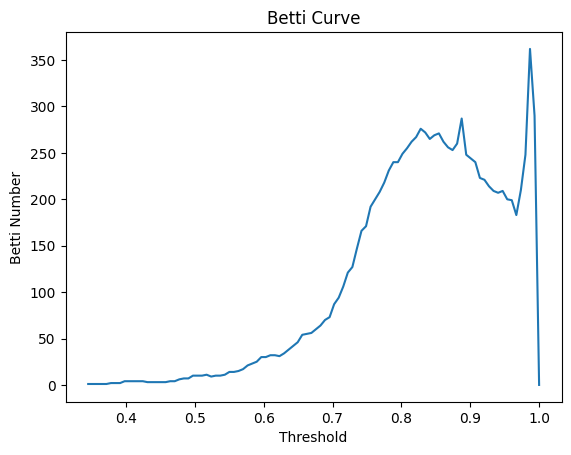

In [64]:

def compute_betti_curve(persistence_diagram, r):
    """
    Compute the Betti curve from a persistence diagram.
    
    Parameters:
    - persistence_diagram: array-like, shape (n, 2)
        A list of (birth, death) points representing the persistence diagram.
    - r: int
        Resolution of the Betti curve, defining the number of points in the curve.
    
    Returns:
    - betti_curve: np.ndarray
        The Betti curve as an array of length r.
    """
    
    # Convert to numpy array for easy manipulation
    persistence_diagram = np.array(persistence_diagram)
    
    # Determine the range for the Betti curve
    min_birth = np.min(persistence_diagram[:, 0])
    max_death = np.max(persistence_diagram[:, 1])
    
    # Generate the sample points where we compute the Betti numbers
    sample_points = np.linspace(min_birth, max_death, r)
    
    # Initialize the Betti curve
    betti_curve = np.zeros(r)
    
    # Compute the Betti curve
    for i, t in enumerate(sample_points):
        # Count intervals that are alive at time t
        betti_curve[i] = np.sum((persistence_diagram[:, 0] <= t) & (persistence_diagram[:, 1] > t))
    
    return sample_points, betti_curve

# Example usage
r = 100
sample_points, betti_curve = compute_betti_curve(pers_array, r)

# Plotting the Betti curve
import matplotlib.pyplot as plt

plt.plot(sample_points, betti_curve)
plt.xlabel("Threshold")
plt.ylabel("Betti Number")
plt.title("Betti Curve")
plt.show()

In [4]:
from model import TopologicalFeatureExtractor

In [10]:
dev = 'cuda:0'
top = TopologicalFeatureExtractor(25)
out = top(im.to(dev))
out.cpu().shape

torch.Size([1, 50])

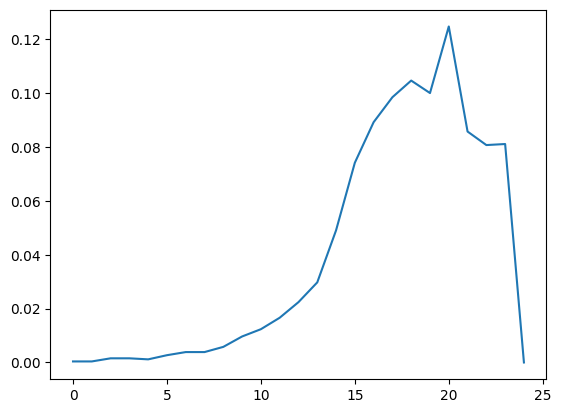

In [11]:
# h0 = out.cpu().squeeze(0)[]
h1 = out.cpu().squeeze(0)[25:]

plt.plot(h1)

## Image captioning

In [4]:
from transformers import AutoProcessor, AutoModelForCausalLM
# from transformers import OFATokenizer, OFAModel

### Git-base model

In [7]:
from datasets import load_dataset
from huggingface_hub import notebook_login

notebook_login()



In [8]:
ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds

DatasetNotFoundError: Dataset 'lambdalabs/pokemon-blip-captions' is a gated dataset on the Hub. Visit the dataset page at https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions to ask for access.

In [54]:
im = Image.open(path)
inputs = processor(images=im, return_tensors='pt')
pixel_values = inputs.pixel_values

In [55]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

the fruit of the tree in my garden.


### ofa-tiny model

In [5]:
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]

resolution = 224

patch_resize_transform = T.Compose([
        # lambda image: image.convert("RGB"),
        T.Resize((resolution, resolution), interpolation=Image.BICUBIC),
        T.ToTensor(), 
        T.Normalize(mean=mean, std=std)
    ])

tokenizer = OFATokenizer.from_pretrained('topology/OFA-medium')


txt = "Describe precisely the image"
inputs = tokenizer([txt, txt], return_tensors="pt").input_ids
img = Image.open(path)

patch_img = patch_resize_transform(img).unsqueeze(0)
patch_img = torch.cat([patch_img, patch_img], dim=0)

model = OFAModel.from_pretrained('topology/OFA-medium', use_cache=False)

gen = model.generate(inputs, patch_images=patch_img, num_beams=20, no_repeat_ngram_size=3) 

print(tokenizer.batch_decode(gen, skip_special_tokens=True))

topology/OFA-medium
<super: <class 'OFATokenizer'>, <OFATokenizer object>>
[' this is an image of a man standing in front of a computer.', ' this is an image of a man standing in front of a computer.']


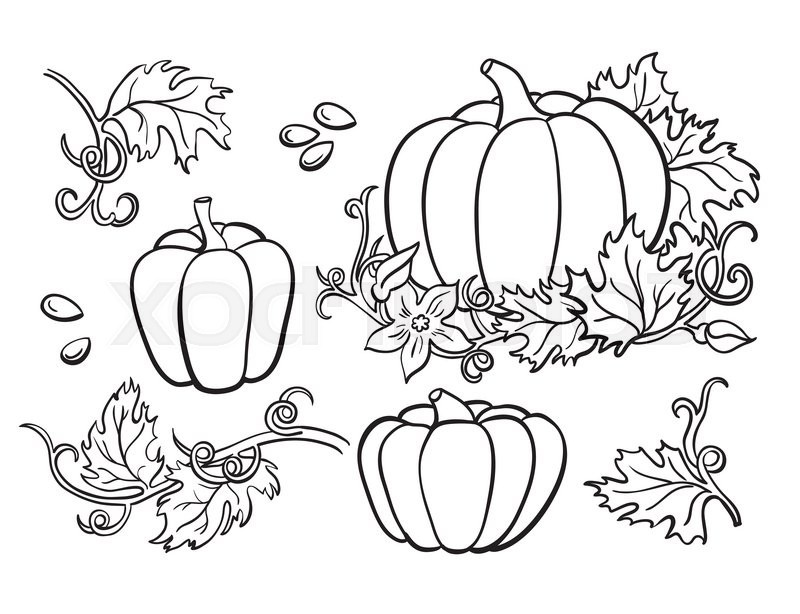

In [26]:
img

## Vision transformer

In [38]:
model = torch.hub.load("ml-jku/MIM-Refiner", "d2v2_refined_h14")
model.eval()

Using cache found in /home/louis/.cache/torch/hub/ml-jku_MIM-Refiner_main


PostnormVit(
  (patch_embed): VitPatchEmbed(
    (proj): Conv2d(3, 1280, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (pos_embed): VitPosEmbed2d()
  (cls_tokens): VitClassTokens()
  (embed_norm): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
  (blocks): ModuleList(
    (0-31): 32 x PostnormBlock(
      (attn): DotProductAttention1d(
        (qkv): Linear(in_features=1280, out_features=3840, bias=True)
        (proj): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (ls1): Identity()
      (drop_path1): DropPath(drop_prob=0.000)
      (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      )
      (ls2): Identity()
      (drop_path2): DropPath(drop_prob=0.000)
      (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True

In [39]:
from PIL import Image

transforms = T.Compose([
    T.Resize((140,140)),
    T.ToTensor()
])

im = Image.open(path)
im_t = transforms(im).unsqueeze(0)
# im_t.shape

In [40]:
out = model(im_t)

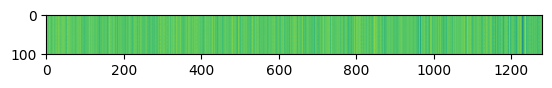

In [42]:
plt.imshow(out.detach().numpy().transpose(1,2,0))

### Custom dataset

allow retriveve pre-computed topological features

In [8]:
entries = sorted(entry.name for entry in os.scandir('data/val_images') if entry.is_dir())

In [10]:
from torchvision.datasets.folder import find_classes

In [11]:
classes, idx = find_classes('data/val_images')

In [24]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    # transforms.Grayscale(),  # Ensure images are single-channel for CubicalComplex
    transforms.Resize((128, 128)),  # Resize to a consistent shape
    transforms.ToTensor()
])

dataset = datasets.ImageFolder(root='data/train_images', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)  # Process images one by one


In [4]:
import polars as pl


In [6]:
df = pl.read_parquet('topology/train_res64_224px_curated.parquet')
df.null_count()

class_name,image_name,topology
u32,u32,u32
0,0,0


In [15]:

df = pl.read_parquet('topology/test_res64_224px_final.parquet')
# df = df.with_columns([
#     pl.col('paths').str.split_exact('/',n=4).alias('paths'),
# ]).unnest('paths').drop(['field_0', 'field_1', 'field_2']).rename({'field_3': 'class_name', 'field_4': 'image_name'})

# df.write_parquet('topology/val_64_224px_final.parquet')
# df = df.with_columns([
#     pl.col('paths').arr.get(-2).alias('class'),
#     pl.col('paths').arr.get(-1).alias('image_name'),
# ])

# df = df.rename({'paths': 'image_name'})
# df.write_parquet('topology/test_res64_224px_final.parquet')
imgs = df['image_name'].to_numpy()
features = df['topology'].to_torch()

t = dict(zip(imgs, features))
t

{'img_v3hkl.jpeg': tensor([0.0004, 0.0006, 0.0011, 0.0013, 0.0019, 0.0028, 0.0032, 0.0051, 0.0066,
         0.0078, 0.0123, 0.0184, 0.0212, 0.0250, 0.0273, 0.0282, 0.0284, 0.0296,
         0.0328, 0.0320, 0.0313, 0.0307, 0.0277, 0.0256, 0.0241, 0.0224, 0.0195,
         0.0216, 0.0195, 0.0186, 0.0172, 0.0205, 0.0237, 0.0288, 0.0299, 0.0292,
         0.0282, 0.0280, 0.0273, 0.0246, 0.0208, 0.0197, 0.0182, 0.0167, 0.0140,
         0.0104, 0.0100, 0.0104, 0.0087, 0.0076, 0.0066, 0.0061, 0.0053, 0.0051,
         0.0053, 0.0044, 0.0044, 0.0040, 0.0034, 0.0030, 0.0061, 0.0227, 0.0028,
         0.0000, 0.0002, 0.0004, 0.0004, 0.0004, 0.0004, 0.0002, 0.0002, 0.0004,
         0.0006, 0.0006, 0.0008, 0.0010, 0.0010, 0.0012, 0.0014, 0.0012, 0.0016,
         0.0020, 0.0024, 0.0026, 0.0039, 0.0041, 0.0053, 0.0065, 0.0069, 0.0087,
         0.0095, 0.0099, 0.0118, 0.0134, 0.0148, 0.0158, 0.0168, 0.0164, 0.0174,
         0.0205, 0.0231, 0.0233, 0.0237, 0.0260, 0.0256, 0.0268, 0.0282, 0.0284,
         0

In [56]:
df = pl.DataFrame({
    "path": ["../data/train_images/class1/image1.jpg", "../data/train_images/class2/image2.jpg"]
})

# Split the path column and extract class name and image name
df = df.with_columns([
    pl.col("path").str.split("/").alias("image_name")   # Extract the last part
])

In [47]:
arr= df['topology'].to_numpy()
arr = np.nan_to_num(arr, nan=0.0)
arr

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00083589, 0.00919476, 0.01365283, ..., 0.0313087 , 0.03882279,
        0.        ],
       [0.00076453, 0.00076453, 0.00152905, ..., 0.04112554, 0.01731602,
        0.        ],
       ...,
       [0.00470418, 0.01501719, 0.018093  , ..., 0.02452768, 0.01839576,
        0.        ],
       [0.00040502, 0.01377076, 0.01579587, ..., 0.02714932, 0.23076923,
        0.        ],
       [0.0011655 , 0.0483683 , 0.03088578, ..., 0.01695942, 0.04421563,
        0.        ]], dtype=float32)

## Swim V2 

In [3]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("microsoft/swinv2-base-patch4-window16-256")
model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window16-256")

In [4]:
model

Swinv2ForImageClassification(
  (swinv2): Swinv2Model(
    (embeddings): Swinv2Embeddings(
      (patch_embeddings): Swinv2PatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Swinv2Encoder(
      (layers): ModuleList(
        (0): Swinv2Stage(
          (blocks): ModuleList(
            (0-1): 2 x Swinv2Layer(
              (attention): Swinv2Attention(
                (self): Swinv2SelfAttention(
                  (continuous_position_bias_mlp): Sequential(
                    (0): Linear(in_features=2, out_features=512, bias=True)
                    (1): ReLU(inplace=True)
                    (2): Linear(in_features=512, out_features=4, bias=False)
                  )
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_featur

In [4]:
import torch.nn as nn

class ClsModel(nn.Module):
    def __init__(self):
        self.model = AutoModelForImageClassification.from_pretrained("microsoft/swinv2-base-patch4-window16-256")
        
        for param in self.model.parameters():
            param.requires_grad = False

        self.model.classifier = nn.Sequential(
            nn.Linear(1024, 512), 
            nn.BatchNorm1D(512), 
            nn.ReLU(), 
            nn.Linear(512, 500), 
            nn.BatchNorm1D(500), 
            nn.ReLU()
        )

    def forward(self, x):
        return self.model(x)

In [12]:
from datasets import load_dataset
from torch.utils.data import DataLoader

dataset = load_dataset('imagefolder', data_dir='data')

Resolving data files:   0%|          | 0/19880 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/2500 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/5455 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [14]:
def process_images(examples):
    images = [image.convert('RGB') for image in examples['image']]
    processed_images = processor(images, return_tensors='pt')
    examples['pixel_values'] = processed_images['pixel_values']
    return examples

In [15]:
dataset = dataset.map(process_images, batched=True)

Map:   0%|          | 0/19880 [00:00<?, ? examples/s]

Map:   0%|          | 0/2500 [00:00<?, ? examples/s]

Map:   0%|          | 0/5455 [00:00<?, ? examples/s]

In [22]:
dataloaders = {}

for split in ['train', 'validation', 'test']:
    train_set[split].set_format('torch', columns=['pixel_values', 'label'])
    dataloaders[split] = DataLoader(train_set[split], batch_size=128, shuffle=(split=='train'))

In [5]:
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification

processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
model = AutoModelForZeroShotImageClassification.from_pretrained("openai/clip-vit-base-patch32")

model

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [2]:
from transformers import AutoModel

In [10]:
net = AutoModel.from_pretrained('facebook/dinov2-small')
net

Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-11): 12 x Dinov2Layer(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2SdpaAttention(
          (attention): Dinov2SdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_pa

In [26]:
from transformers import AutoImageProcessor, Dinov2ForImageClassification

model = Dinov2ForImageClassification.from_pretrained("facebook/dinov2-base")
model

Some weights of Dinov2ForImageClassification were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Dinov2ForImageClassification(
  (dinov2): Dinov2Model(
    (embeddings): Dinov2Embeddings(
      (patch_embeddings): Dinov2PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(14, 14), stride=(14, 14))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): Dinov2Encoder(
      (layer): ModuleList(
        (0-11): 12 x Dinov2Layer(
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (attention): Dinov2SdpaAttention(
            (attention): Dinov2SdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): Dinov2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)

In [23]:
from transformers import AutoImageProcessor, ConvNextV2Model, ConvNextV2ForImageClassification
model = ConvNextV2ForImageClassification.from_pretrained("facebook/convnextv2-tiny-1k-224")
model.convnextv2

ConvNextV2Model(
  (embeddings): ConvNextV2Embeddings(
    (patch_embeddings): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (layernorm): ConvNextV2LayerNorm()
  )
  (encoder): ConvNextV2Encoder(
    (stages): ModuleList(
      (0): ConvNextV2Stage(
        (downsampling_layer): Identity()
        (layers): Sequential(
          (0): ConvNextV2Layer(
            (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (layernorm): ConvNextV2LayerNorm()
            (pwconv1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELUActivation()
            (grn): ConvNextV2GRN()
            (pwconv2): Linear(in_features=384, out_features=96, bias=True)
            (drop_path): Identity()
          )
          (1): ConvNextV2Layer(
            (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (layernorm): ConvNextV2LayerNorm()
            (pwconv1): Linear(in_features=96, o

In [13]:
import torch.nn as nn
for params in model.parameters():
    params.requires_grad=False

model.classifier = nn.Linear(768,500)

In [16]:
# for params in model.classifier.parameters():
#     print(params)
for params in model.parameters():
    print(params.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
Fals